In [73]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt


In [74]:
df = pd.read_csv('merged_df.csv', index_col=None)

# remove outliers
# remove absence_range, finalResult, 
df = df.drop(['absences_range', 'finalResult'], axis=1)
df = df[df['absences'] < 20]

### Columns pre selection removing G1 and G2

In [79]:
#  transform all non object to object type
df[['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel','freetime', 'goout', 
    'Dalc', 'Walc', 'health']] = df[['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel','freetime', 'goout', 'Dalc', 'Walc', 'health']].astype('object') 

columns_cat = df[['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health']]

continue_cols = df[['age','absences', 'G1']]

# cocat in a new dataframe
df_cat = pd.concat([columns_cat, continue_cols], axis=1)


### Columns transformation and encoding

In [80]:
X = df_cat
ct = make_column_transformer(
      (MinMaxScaler(),
       make_column_selector(dtype_include=np.number)),
      (OneHotEncoder(),
       make_column_selector(dtype_include=object)))

# Apply the column transformer to the data
X_preprocessed = ct.fit_transform(X)  

# Create a new dataframe with the preprocessing applied
feature_names = ct.get_feature_names_out()
new_df = pd.DataFrame(X_preprocessed, columns=feature_names)

### Train test and split

In [81]:
# train test split
X = new_df
y = df['G3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [82]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
# check ms and r2
print('Linear Regression')
print('Mean squared error: %.2f'
        % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f'
        % r2_score(y_test, y_pred))


Linear Regression
Mean squared error: 4.99
Coefficient of determination: 0.66


### Function to train and fine tune a model

In [64]:
def evaluate_models(X_train, X_test, y_train, y_test):

    # Create pipelines for each model
    knn_pipeline = Pipeline(steps=[
        ('regressor', KNeighborsRegressor())
    ])

    dt_pipeline = Pipeline(steps=[
        ('regressor', DecisionTreeRegressor())
    ])

    linear_pipeline = Pipeline(steps=[
        ('regressor', LinearRegression())
    ])

    # Define hyperparameter search spaces for each pipeline
    knn_params = {'regressor__n_neighbors': [3, 5, 7, 9, 11],
                  'regressor__weights': ['uniform', 'distance'],
                  'regressor__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                  'regressor__leaf_size': [10, 20, 30, 40, 50],
                  'regressor__p': [1, 2]}

    dt_params = {'regressor__criterion': ['friedman_mse', 'squared_error', 'poisson', 'absolute_error'],
                 'regressor__splitter': ['best', 'random'],
                 'regressor__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                 'regressor__min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                 'regressor__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

    # Create a dictionary containing all the pipelines and their corresponding hyperparameter search spaces
    pipelines = {
        'knn': (knn_pipeline, knn_params),
        'dt': (dt_pipeline, dt_params),
        'linear': (linear_pipeline, {})
    }

    # Create lists to store the pipeline names, MSE values, and R-squared values
    pipeline_names = []
    mse_values = []
    r2_values = []

    # Perform grid search for each pipeline
    for pipeline_name, (pipeline, param_grid) in pipelines.items():
        print(f"Performing grid search for pipeline: {pipeline_name}")
        grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        y_pred = grid_search.predict(X_test)

        # Compute metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Add pipeline name, MSE value, and R-squared value to the lists
        pipeline_names.append(pipeline_name)
        mse_values.append(mse)
        r2_values.append(r2)

        #print(f"Best parameters for {pipeline_name}: {grid_search.best_params_}")
        #print(f"Mean squared error: {mse:.3f}")
        #print(f"R-squared: {r2:.3f}")
    return grid_search, y_pred, pipeline_names, mse_values, r2_values

## Light Features (No G1 and G2)

In [65]:
eval_ligh = evaluate_models(X_train, X_test, y_train, y_test)

Performing grid search for pipeline: knn
Performing grid search for pipeline: dt
Performing grid search for pipeline: linear


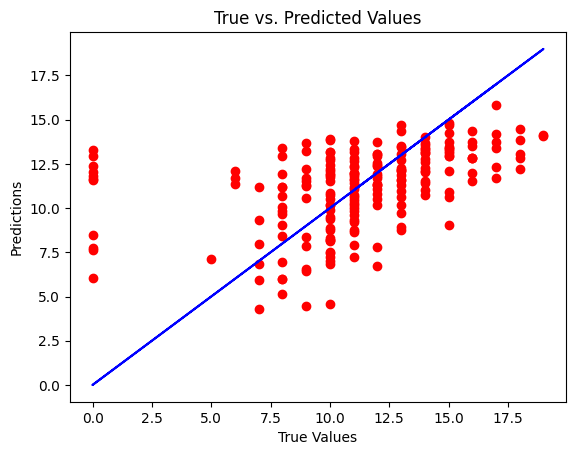

Pipeline(steps=[('regressor', LinearRegression())])
Mean squared error: 0.12
Coefficient of determination: 0.17


In [99]:
# assuming y_test and y_pred are defined from your code
plt.scatter(y_test, eval_ligh[1], color='red')
plt.plot(y_test, y_test, color='blue')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')
# display the distance between the line and the points
plt.show()

# print the best model
print(eval_ligh[0].best_estimator_)
# print mse and r2 of the best model
print('Mean squared error: %.2f'
        % eval_ligh[0].best_score_)
print('Coefficient of determination: %.2f'
        % r2_score(y_test, eval_ligh[1]))


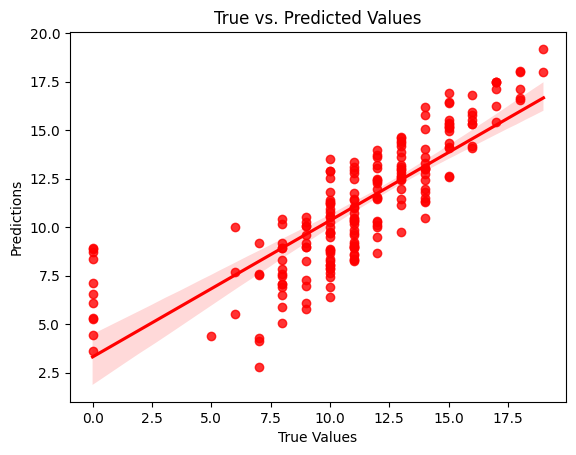

best model is :Pipeline(steps=[('regressor', LinearRegression())])
Mean squared error: 12.40
Coefficient of determination: 0.17


In [102]:

# Create scatter plot with regression line using Seaborn
sns.regplot(x=y_test, y=y_pred, color='red')

# Add labels and title using Matplotlib
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')

# Display the plot
plt.show()

# print the best model
print(f'best model is :{eval_ligh[0].best_estimator_}')
# mse and r2
print('Mean squared error: %.2f'
        % mean_squared_error(y_test, eval_ligh[1]))
print('Coefficient of determination: %.2f'
        % r2_score(y_test, eval_ligh[1]))


## Adding G1

In [ ]:
#  transform all non object to object type
df[['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel','freetime', 'goout', 
    'Dalc', 'Walc', 'health']] = df[['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel','freetime', 'goout', 'Dalc', 'Walc', 'health']].astype('object') 

columns_cat = df[['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health']]

continue_cols = df[['age','absences', 'G1']]

# cocat in a new dataframe
df_cat = pd.concat([columns_cat, continue_cols], axis=1)

# Create a column transformer
X = df_cat
ct = make_column_transformer(
      (MinMaxScaler(),
       make_column_selector(dtype_include=np.number)),
      (OneHotEncoder(),
       make_column_selector(dtype_include=object)))

# Apply the column transformer to the data
X_preprocessed = ct.fit_transform(X)  

# Create a new dataframe with the preprocessing applied
feature_names = ct.get_feature_names_out()
new_df = pd.DataFrame(X_preprocessed, columns=feature_names)


# train test split
X = new_df
y = df['G3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train the model
best_model, grid_search = evaluate_models(X_train, X_test, y_train, y_test)

# evaluate the model
y_pred = grid_search.predict(X_test)


## Adding G2

In [ ]:
#  transform all non object to object type
df[['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel','freetime', 'goout', 
    'Dalc', 'Walc', 'health']] = df[['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel','freetime', 'goout', 'Dalc', 'Walc', 'health']].astype('object') 

columns_cat = df[['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health']]

continue_cols = df[['age','absences', 'G2']]

# cocat in a new dataframe
df_cat = pd.concat([columns_cat, continue_cols], axis=1)

# Create a column transformer
X = df_cat
ct = make_column_transformer(
      (MinMaxScaler(),
       make_column_selector(dtype_include=np.number)),
      (OneHotEncoder(),
       make_column_selector(dtype_include=object)))

# Apply the column transformer to the data
X_preprocessed = ct.fit_transform(X)  

# Create a new dataframe with the preprocessing applied
feature_names = ct.get_feature_names_out()
new_df = pd.DataFrame(X_preprocessed, columns=feature_names)


# train test split
X = new_df
y = df['G3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train the model
best_model, grid_search = evaluate_models(X_train, X_test, y_train, y_test)

# evaluate the model
y_pred = grid_search.predict(X_test)

## Adding G1 and G2

In [ ]:
#  transform all non object to object type
df[['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel','freetime', 'goout', 
    'Dalc', 'Walc', 'health']] = df[['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel','freetime', 'goout', 'Dalc', 'Walc', 'health']].astype('object') 

columns_cat = df[['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health']]

continue_cols = df[['age','absences', 'G1','G2']]

# cocat in a new dataframe
df_cat = pd.concat([columns_cat, continue_cols], axis=1)

# Create a column transformer
X = df_cat
ct = make_column_transformer(
      (MinMaxScaler(),
       make_column_selector(dtype_include=np.number)),
      (OneHotEncoder(),
       make_column_selector(dtype_include=object)))

# Apply the column transformer to the data
X_preprocessed = ct.fit_transform(X)  

# Create a new dataframe with the preprocessing applied
feature_names = ct.get_feature_names_out()
new_df = pd.DataFrame(X_preprocessed, columns=feature_names)


# train test split
X = new_df
y = df['G3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train the model
best_model, grid_search = evaluate_models(X_train, X_test, y_train, y_test)

# evaluate the model
y_pred = grid_search.predict(X_test)
